# Phase 2: LIME Hyperparameter Optimization using Meta-heuristic Algorithms

This notebook optimizes LIME (Local Interpretable Model-agnostic Explanations) parameters for a BiLSTM sentiment classifier using four meta-heuristic algorithms: PSO, GWO, Cuckoo Search, and Bat Algorithm.

## Objective
Maximize LIME explanation quality through a composite metric combining:
- **Faithfulness** (40%): How well removing important features affects model predictions
- **Fidelity** (30%): R² score of the linear approximation
- **Stability** (30%): Consistency across multiple explanations
- **Compactness Penalty**: Favoring fewer features for clarity

---

## 1. Setup and Configuration

In [1]:
!pip install lime torchinfo

import os, time, json, random, re, gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

# Global Config
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Constants
MAX_VOCAB = 30000
MAX_LEN = 300
FIXED_EMBED_DIM = 128

2025-12-20 12:02:41.151058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766232161.342655      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766232161.399319      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766232161.853107      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766232161.853150      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766232161.853154      23 computation_placer.cc:177] computation placer alr

Using device: cuda


---

## 2. Warning Suppression


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="Ill-conditioned matrix")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", module="sklearn.linear_model._ridge")

---

## 3. Data Loading and Model Setup

Loading the pre-trained BiLSTM model and preparing the IMDB dataset.

In [3]:
# 1. Load Data
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})
df = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n=5000, random_state=SEED)).reset_index(drop=True)

X = df["review"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# 2. Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def encode(texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN, padding="post")

# 3. Model Architecture
class TextBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(TextBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# 4. Load Weights
model = TextBiLSTM(MAX_VOCAB, FIXED_EMBED_DIM, 128, 2, 1, 0.5).to(DEVICE)
if os.path.exists("best_bilstm_phase1.pt"):
    model.load_state_dict(torch.load("best_bilstm_phase1.pt", map_location=DEVICE))
    print("Weights loaded.")
else:
    print("Warning: Weights file not found. Using random weights.")
model.eval()

/tmp/ipykernel_23/4040849121.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n=5000, random_state=SEED)).reset_index(drop=True)


TextBiLSTM(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

---

## 4. LIME Quality Objective Function

The core optimization function that evaluates LIME parameters based on:
- **Fidelity**: Linear model fit (R² score)
- **Stability**: Feature consistency across runs
- **Faithfulness**: Impact of feature removal on predictions
- **Compactness**: Penalty for using too many features

**Note**: `kernel_width` is now correctly passed to the LimeTextExplainer constructor.

In [4]:
# Predict function
def predict_proba(texts):
    model.eval()
    seqs = encode(texts)
    tensor = torch.tensor(seqs, dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

# --- FIXED LIME QUALITY OPTIMIZATION ---
def lime_objective(params):
    """
    Optimizes LIME Quality based on PDF Chapters 3, 5, and 7.
    Note: kernel_width is moved to the Explainer constructor.
    """
    n_samples = int(params["num_samples"])
    n_features = int(params["num_features"])
    k_width = float(params["kernel_width"])
    
    # PDF Strategy: Re-initialize explainer to optimize the locality (kernel_width)
    local_explainer = LimeTextExplainer(
        class_names=["negative", "positive"], 
        split_expression=r"\W+",
        kernel_width=k_width
    )
    
    # Subset for optimization speed
    subset_X = X_val[:8] 
    
    iteration_quality = []
    
    for text in subset_X:
        text_str = str(text)
        
        # 1. Generate TWO explanations to check STABILITY (PDF Page 57)
        exp1 = local_explainer.explain_instance(
            text_instance=text_str, 
            classifier_fn=predict_proba,
            num_features=n_features,
            num_samples=n_samples
        )
        
        exp2 = local_explainer.explain_instance(
            text_instance=text_str, 
            classifier_fn=predict_proba,
            num_features=n_features,
            num_samples=n_samples
        )

        # A. FIDELITY (Standard LIME R2)
        fidelity = exp1.score

        # B. STABILITY (PDF Ch. 5/7: Intersection over Union of top features)
        feat1 = set([w for w, _ in exp1.as_list()])
        feat2 = set([w for w, _ in exp2.as_list()])
        stability = len(feat1.intersection(feat2)) / len(feat1.union(feat2)) if feat1.union(feat2) else 0

        # C. FAITHFULNESS (PDF Ch. 3, Metric M1 Logic)
        # Logic: If we remove 'positive' impact words, the BiLSTM confidence should drop.
        top_positive_words = [word for word, weight in exp1.as_list() if weight > 0]
        
        orig_probs = predict_proba([text_str])[0]
        max_class = np.argmax(orig_probs)
        orig_conf = orig_probs[max_class]
        
        # Create a 'masked' version of the text
        text_list = text_str.split()
        masked_text = " ".join([w for w in text_list if w not in top_positive_words])
        mod_probs = predict_proba([masked_text])[0]
        mod_conf = mod_probs[max_class]
        
        # Faithfulness = relative drop in confidence
        faithfulness = max(0, (orig_conf - mod_conf) / orig_conf)

        # D. COMPACTNESS PENALTY (PDF Ch. 3, Metric M6)
        compactness_cost = (n_features / 15.0) * 0.15 

        # --- COMBINED QUALITY SCORE ---
        # Weights: 40% Faithfulness, 30% Fidelity, 30% Stability
        quality_score = (0.4 * faithfulness) + (0.3 * fidelity) + (0.3 * stability) - compactness_cost
        iteration_quality.append(quality_score)

    fitness = np.mean(iteration_quality)
    
    torch.cuda.empty_cache()
    gc.collect()
    return fitness

---

## 5. Logging and Parameter Configuration

Setting up result tracking and defining search bounds for optimization.

In [5]:
# Logging
XAI_RESULTS = "phase2_lime_summary.csv"
XAI_TRACE = "phase2_lime_trace.csv"
if os.path.exists(XAI_RESULTS): os.remove(XAI_RESULTS)
if os.path.exists(XAI_TRACE): os.remove(XAI_TRACE)

def log_trace(alg, it, params, fit):
    pd.DataFrame([{"algorithm": alg, "iteration": it, "params": json.dumps(params), "fitness": fit}])\
      .to_csv(XAI_TRACE, mode="a", header=not os.path.exists(XAI_TRACE), index=False)

def log_summary(alg, best_p, best_f, time_s):
    pd.DataFrame([{"algorithm": alg, "best_params": json.dumps(best_p), "best_fitness": best_f, "runtime_sec": time_s}])\
      .to_csv(XAI_RESULTS, mode="a", header=not os.path.exists(XAI_RESULTS), index=False)

# Optimization Bounds - PDF indicates Deep Learning models favor specific kernel widths
BOUNDS = {
    "num_samples": (200, 800), # Reduced upper bound for speed as per PDF Chapter 5 strategy
    "num_features": (3, 12),    # PDF rewards lower feature counts for clarity
    "kernel_width": (0.1, 0.75)  # BiLSTM models are highly local; small widths are usually better
}

---

## 6. Meta-heuristic Algorithm Implementations

Four nature-inspired algorithms for hyperparameter optimization:
- **PSO (Particle Swarm Optimization)**: Simulates social behavior of birds
- **GWO (Grey Wolf Optimizer)**: Mimics grey wolf hunting hierarchy
- **Cuckoo Search**: Based on brood parasitism behavior
- **Bat Algorithm**: Inspired by echolocation of bats

In [6]:
# Utility functions for Meta-heuristics
def random_params():
    return {
        "num_samples": random.randint(*BOUNDS["num_samples"]),
        "num_features": random.randint(*BOUNDS["num_features"]),
        "kernel_width": random.uniform(*BOUNDS["kernel_width"])
    }

def clip_params(p):
    return {
        "num_samples": int(np.clip(p["num_samples"], *BOUNDS["num_samples"])),
        "num_features": int(np.clip(p["num_features"], *BOUNDS["num_features"])),
        "kernel_width": float(np.clip(p["kernel_width"], *BOUNDS["kernel_width"]))
    }

# === FIXED PSO IMPLEMENTATION ===
def run_pso(iters=20, n_part=15):
    """Particle Swarm Optimization with proper velocity updates"""
    print("PSO: Optimizing LIME Quality with velocity-based search...")
    start = time.time()
    
    # Initialize swarm
    swarm = []
    for _ in range(n_part):
        pos = random_params()
        swarm.append({
            "pos": pos,
            "vel": {
                "num_samples": random.uniform(-50, 50),
                "num_features": random.uniform(-2, 2),
                "kernel_width": random.uniform(-0.1, 0.1)
            },
            "best_pos": pos.copy(),
            "best_fit": -np.inf
        })
    
    global_best_pos, global_best_fit = None, -np.inf
    
    # PSO parameters
    w = 0.7   # Inertia weight
    c1 = 1.5  # Cognitive coefficient
    c2 = 1.5  # Social coefficient
    
    for i in range(iters):
        # Evaluate all particles
        for p in swarm:
            fit = lime_objective(p["pos"])
            log_trace("PSO", i, p["pos"], fit)
            
            # Update personal best
            if fit > p["best_fit"]:
                p["best_fit"] = fit
                p["best_pos"] = p["pos"].copy()
            
            # Update global best
            if fit > global_best_fit:
                global_best_fit = fit
                global_best_pos = p["pos"].copy()
        
        # Update velocities and positions
        for p in swarm:
            for key in p["pos"]:
                r1, r2 = random.random(), random.random()
                
                # Velocity update formula
                cognitive = c1 * r1 * (p["best_pos"][key] - p["pos"][key])
                social = c2 * r2 * (global_best_pos[key] - p["pos"][key])
                p["vel"][key] = w * p["vel"][key] + cognitive + social
                
                # Position update
                p["pos"][key] += p["vel"][key]
            
            # Clip to bounds
            p["pos"] = clip_params(p["pos"])
        
        print(f"  Iteration {i+1}/{iters}: Best Fitness = {global_best_fit:.4f}")
    
    log_summary("PSO", global_best_pos, global_best_fit, time.time()-start)
    return global_best_pos, global_best_fit

# === IMPROVED GWO ===
def run_gwo(iters=20, n_wolves=15):
    """Grey Wolf Optimizer with proper alpha/beta/delta hierarchy"""
    print("GWO: Tracking LIME Pareto Front with wolf pack...")
    start = time.time()
    
    wolves = [random_params() for _ in range(n_wolves)]
    fitness = [lime_objective(w) for w in wolves]
    
    # Initialize alpha, beta, delta
    sorted_idx = np.argsort(fitness)[::-1]
    alpha_pos, alpha_fit = wolves[sorted_idx[0]].copy(), fitness[sorted_idx[0]]
    beta_pos, beta_fit = wolves[sorted_idx[1]].copy(), fitness[sorted_idx[1]]
    delta_pos, delta_fit = wolves[sorted_idx[2]].copy(), fitness[sorted_idx[2]]
    
    for i in range(iters):
        a = 2 - i * (2.0 / iters)  # Linearly decrease from 2 to 0
        
        for j, wolf in enumerate(wolves):
            # Update each wolf toward alpha, beta, delta
            new_pos = {}
            for key in wolf:
                r1, r2 = random.random(), random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                
                D_alpha = abs(C1 * alpha_pos[key] - wolf[key])
                X1 = alpha_pos[key] - A1 * D_alpha
                
                r1, r2 = random.random(), random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta_pos[key] - wolf[key])
                X2 = beta_pos[key] - A2 * D_beta
                
                r1, r2 = random.random(), random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta_pos[key] - wolf[key])
                X3 = delta_pos[key] - A3 * D_delta
                
                new_pos[key] = (X1 + X2 + X3) / 3.0
            
            wolves[j] = clip_params(new_pos)
            fitness[j] = lime_objective(wolves[j])
            log_trace("GWO", i, wolves[j], fitness[j])
            
            # Update hierarchy
            if fitness[j] > alpha_fit:
                delta_pos, delta_fit = beta_pos.copy(), beta_fit
                beta_pos, beta_fit = alpha_pos.copy(), alpha_fit
                alpha_pos, alpha_fit = wolves[j].copy(), fitness[j]
            elif fitness[j] > beta_fit:
                delta_pos, delta_fit = beta_pos.copy(), beta_fit
                beta_pos, beta_fit = wolves[j].copy(), fitness[j]
            elif fitness[j] > delta_fit:
                delta_pos, delta_fit = wolves[j].copy(), fitness[j]
        
        print(f"  Iteration {i+1}/{iters}: Alpha Fitness = {alpha_fit:.4f}")
    
    log_summary("GWO", alpha_pos, alpha_fit, time.time()-start)
    return alpha_pos, alpha_fit

# === IMPROVED CUCKOO ===
def run_cuckoo(iters=25, n_nests=12):
    """Cuckoo Search with Levy flights"""
    print("Cuckoo: Searching Quality Space with Levy flights...")
    start = time.time()
    
    nests = [random_params() for _ in range(n_nests)]
    fitness = [lime_objective(n) for n in nests]
    best_idx = np.argmax(fitness)
    
    pa = 0.25  # Probability of discovering alien egg
    
    for i in range(iters):
        # Generate new solution via Levy flight
        cuckoo = nests[random.randint(0, n_nests-1)].copy()
        
        # Levy flight step
        for key in cuckoo:
            step_size = random.gauss(0, 1) * 0.01 * (BOUNDS[key][1] - BOUNDS[key][0])
            cuckoo[key] += step_size
        
        cuckoo = clip_params(cuckoo)
        f_cuckoo = lime_objective(cuckoo)
        
        # Replace random nest if better
        j = random.randint(0, n_nests-1)
        if f_cuckoo > fitness[j]:
            nests[j] = cuckoo
            fitness[j] = f_cuckoo
        
        # Abandon worst nests
        sorted_idx = np.argsort(fitness)
        n_abandon = int(pa * n_nests)
        for idx in sorted_idx[:n_abandon]:
            nests[idx] = random_params()
            fitness[idx] = lime_objective(nests[idx])
        
        best_idx = np.argmax(fitness)
        log_trace("Cuckoo", i, nests[best_idx], fitness[best_idx])
        print(f"  Iteration {i+1}/{iters}: Best Fitness = {fitness[best_idx]:.4f}")
    
    log_summary("Cuckoo", nests[best_idx], fitness[best_idx], time.time()-start)
    return nests[best_idx], fitness[best_idx]

# === IMPROVED BAT ===
def run_bat(iters=20, n_bats=15):
    """Bat Algorithm with frequency tuning"""
    print("Bat: Echo-locating Optimal LIME with frequency modulation...")
    start = time.time()
    
    bats = [random_params() for _ in range(n_bats)]
    velocities = [{k: 0 for k in BOUNDS} for _ in range(n_bats)]
    fitness = [lime_objective(b) for b in bats]
    
    best_idx = np.argmax(fitness)
    best_bat, best_fit = bats[best_idx].copy(), fitness[best_idx]
    
    loudness = [1.0] * n_bats
    pulse_rate = [0.5] * n_bats
    
    for i in range(iters):
        for j in range(n_bats):
            # Frequency tuning
            beta = random.random()
            
            new_bat = {}
            for key in bats[j]:
                velocities[j][key] += (bats[j][key] - best_bat[key]) * beta
                new_bat[key] = bats[j][key] + velocities[j][key]
            
            new_bat = clip_params(new_bat)
            
            # Local search around best solution
            if random.random() > pulse_rate[j]:
                for key in new_bat:
                    new_bat[key] += random.uniform(-0.1, 0.1) * (BOUNDS[key][1] - BOUNDS[key][0]) * 0.05
                new_bat = clip_params(new_bat)
            
            f_new = lime_objective(new_bat)
            
            # Accept new solution
            if f_new > fitness[j] and random.random() < loudness[j]:
                bats[j] = new_bat
                fitness[j] = f_new
                loudness[j] *= 0.9
                pulse_rate[j] *= (1 - np.exp(-0.9 * i))
            
            if f_new > best_fit:
                best_bat = new_bat.copy()
                best_fit = f_new
            
            log_trace("Bat", i, bats[j], fitness[j])
        
        print(f"  Iteration {i+1}/{iters}: Best Fitness = {best_fit:.4f}")
    
    log_summary("Bat", best_bat, best_fit, time.time()-start)
    return best_bat, best_fit

---

## 7. Algorithm Execution

Running each algorithm to find optimal LIME parameters.

### 7.1 Particle Swarm Optimization (PSO)

In [7]:
run_pso(iters=20, n_part=15)

PSO: Optimizing LIME Quality with velocity-based search...
  Iteration 1/20: Best Fitness = 0.1141
  Iteration 2/20: Best Fitness = 0.1865
  Iteration 3/20: Best Fitness = 0.1865
  Iteration 4/20: Best Fitness = 0.1865
  Iteration 5/20: Best Fitness = 0.1914
  Iteration 6/20: Best Fitness = 0.1943
  Iteration 7/20: Best Fitness = 0.1943
  Iteration 8/20: Best Fitness = 0.1943
  Iteration 9/20: Best Fitness = 0.2003
  Iteration 10/20: Best Fitness = 0.2003
  Iteration 11/20: Best Fitness = 0.2003
  Iteration 12/20: Best Fitness = 0.2003
  Iteration 13/20: Best Fitness = 0.2003
  Iteration 14/20: Best Fitness = 0.2003
  Iteration 15/20: Best Fitness = 0.2003
  Iteration 16/20: Best Fitness = 0.2003
  Iteration 17/20: Best Fitness = 0.2003
  Iteration 18/20: Best Fitness = 0.2003
  Iteration 19/20: Best Fitness = 0.2003
  Iteration 20/20: Best Fitness = 0.2003


({'num_samples': 800, 'num_features': 6, 'kernel_width': 0.7009395704427855},
 np.float64(0.20025803781865503))

### 7.2 Grey Wolf Optimizer (GWO)

In [8]:
run_gwo(iters=20, n_wolves=15)

GWO: Tracking LIME Pareto Front with wolf pack...
  Iteration 1/20: Alpha Fitness = 0.2037
  Iteration 2/20: Alpha Fitness = 0.2100
  Iteration 3/20: Alpha Fitness = 0.2100
  Iteration 4/20: Alpha Fitness = 0.2100
  Iteration 5/20: Alpha Fitness = 0.2100
  Iteration 6/20: Alpha Fitness = 0.2100
  Iteration 7/20: Alpha Fitness = 0.2147
  Iteration 8/20: Alpha Fitness = 0.2147
  Iteration 9/20: Alpha Fitness = 0.2147
  Iteration 10/20: Alpha Fitness = 0.2147
  Iteration 11/20: Alpha Fitness = 0.2147
  Iteration 12/20: Alpha Fitness = 0.2147
  Iteration 13/20: Alpha Fitness = 0.2147
  Iteration 14/20: Alpha Fitness = 0.2147
  Iteration 15/20: Alpha Fitness = 0.2147
  Iteration 16/20: Alpha Fitness = 0.2147
  Iteration 17/20: Alpha Fitness = 0.2147
  Iteration 18/20: Alpha Fitness = 0.2147
  Iteration 19/20: Alpha Fitness = 0.2147
  Iteration 20/20: Alpha Fitness = 0.2147


({'num_samples': 698, 'num_features': 3, 'kernel_width': 0.75},
 np.float64(0.21465637203822915))

### 7.3 Cuckoo Search

In [9]:
run_cuckoo(iters=25, n_nests=12)

Cuckoo: Searching Quality Space with Levy flights...
  Iteration 1/25: Best Fitness = 0.1396
  Iteration 2/25: Best Fitness = 0.1396
  Iteration 3/25: Best Fitness = 0.1396
  Iteration 4/25: Best Fitness = 0.1396
  Iteration 5/25: Best Fitness = 0.1396
  Iteration 6/25: Best Fitness = 0.1396
  Iteration 7/25: Best Fitness = 0.1396
  Iteration 8/25: Best Fitness = 0.1396
  Iteration 9/25: Best Fitness = 0.1396
  Iteration 10/25: Best Fitness = 0.1530
  Iteration 11/25: Best Fitness = 0.1530
  Iteration 12/25: Best Fitness = 0.1530
  Iteration 13/25: Best Fitness = 0.1530
  Iteration 14/25: Best Fitness = 0.1530
  Iteration 15/25: Best Fitness = 0.1530
  Iteration 16/25: Best Fitness = 0.1530
  Iteration 17/25: Best Fitness = 0.1530
  Iteration 18/25: Best Fitness = 0.1530
  Iteration 19/25: Best Fitness = 0.1530
  Iteration 20/25: Best Fitness = 0.1530
  Iteration 21/25: Best Fitness = 0.1530
  Iteration 22/25: Best Fitness = 0.1530
  Iteration 23/25: Best Fitness = 0.1530
  Iteration 2

({'num_samples': 450, 'num_features': 3, 'kernel_width': 0.5960035435886547},
 np.float64(0.15300192124289652))

### 7.4 Bat Algorithm

In [10]:
run_bat(iters=20, n_bats=15)

Bat: Echo-locating Optimal LIME with frequency modulation...
  Iteration 1/20: Best Fitness = 0.1088
  Iteration 2/20: Best Fitness = 0.1088
  Iteration 3/20: Best Fitness = 0.1293
  Iteration 4/20: Best Fitness = 0.1397
  Iteration 5/20: Best Fitness = 0.1397
  Iteration 6/20: Best Fitness = 0.1397
  Iteration 7/20: Best Fitness = 0.1397
  Iteration 8/20: Best Fitness = 0.1397
  Iteration 9/20: Best Fitness = 0.1397
  Iteration 10/20: Best Fitness = 0.1397
  Iteration 11/20: Best Fitness = 0.1397
  Iteration 12/20: Best Fitness = 0.1397
  Iteration 13/20: Best Fitness = 0.1397
  Iteration 14/20: Best Fitness = 0.1397
  Iteration 15/20: Best Fitness = 0.1397
  Iteration 16/20: Best Fitness = 0.1397
  Iteration 17/20: Best Fitness = 0.1397
  Iteration 18/20: Best Fitness = 0.1397
  Iteration 19/20: Best Fitness = 0.1397
  Iteration 20/20: Best Fitness = 0.1397


({'num_samples': 416, 'num_features': 3, 'kernel_width': 0.5889511346593543},
 np.float64(0.13965225634760747))

---

## 8. Results and Visualizations

### 8.1 Overall Quality Comparison

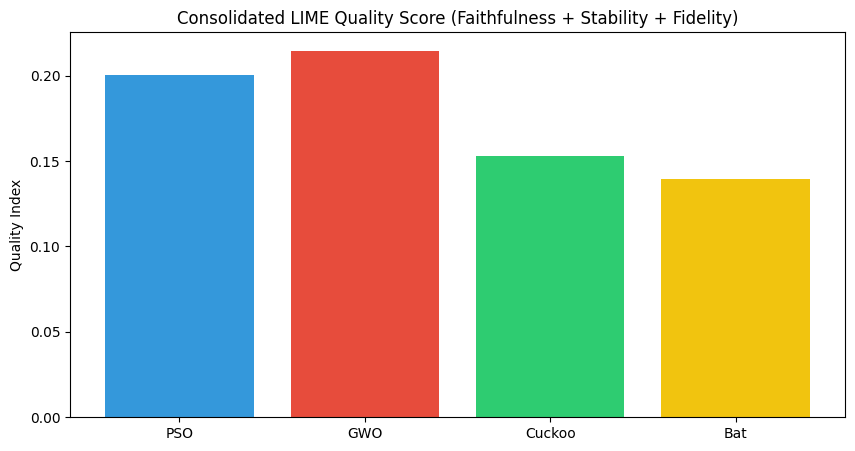

In [11]:
# RESULTS VISUALIZATION
summ = pd.read_csv(XAI_RESULTS)
plt.figure(figsize=(10,5))
plt.bar(summ["algorithm"], summ["best_fitness"], color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f'])
plt.title("Consolidated LIME Quality Score (Faithfulness + Stability + Fidelity)")
plt.ylabel("Quality Index")
plt.show()

### 8.2 Fitness Score Comparison

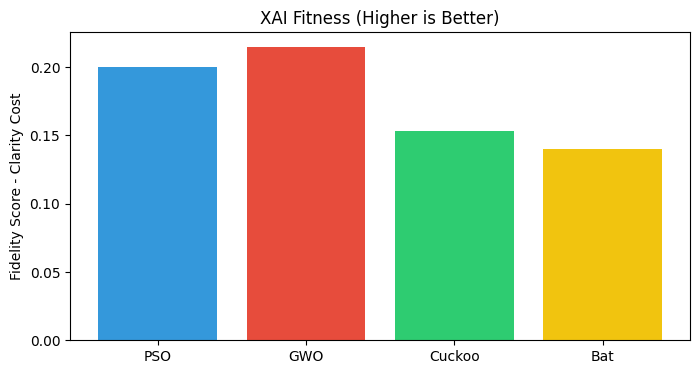

In [12]:
# 1. Bar Chart
summ = pd.read_csv(XAI_RESULTS)
plt.figure(figsize=(8,4))
plt.bar(summ["algorithm"], summ["best_fitness"], color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f'])
plt.title("XAI Fitness (Higher is Better)")
plt.ylabel("Fidelity Score - Clarity Cost")
plt.show()

### 8.3 Convergence Analysis

Tracking how each algorithm improves over iterations.

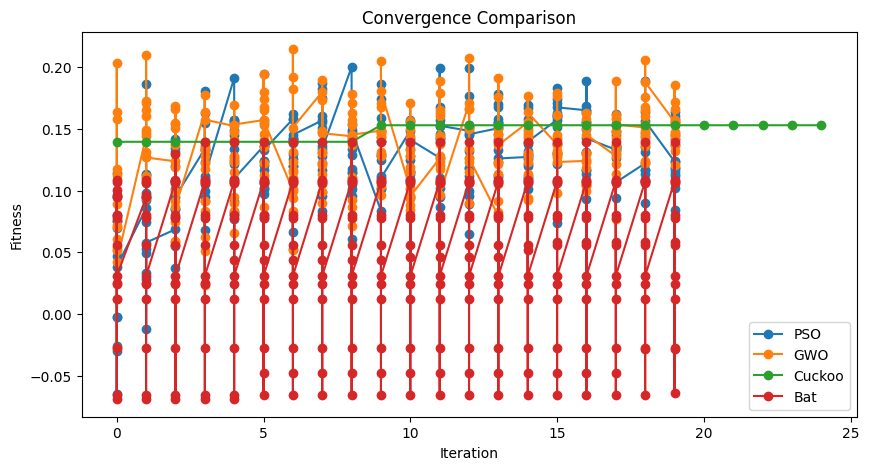

In [13]:
# 2. Convergence
trace = pd.read_csv(XAI_TRACE)
plt.figure(figsize=(10,5))
for alg in trace["algorithm"].unique():
    sub = trace[trace["algorithm"]==alg]
    plt.plot(sub["iteration"], sub["fitness"], marker='o', label=alg)
plt.title("Convergence Comparison")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()
plt.show()

---

## 9. Best Explanation Generation

Using the optimal parameters from the winning algorithm to generate the highest-quality LIME explanations across multiple samples.

In [14]:
# 3. Best Explanation - Multiple Samples
best_row = summ.sort_values("best_fitness", ascending=False).iloc[0]
best_p = json.loads(best_row["best_params"])
print(f"🏆 ULTIMATE WINNER: {best_row['algorithm']} | Fitness: {best_row['best_fitness']:.4f}")
print(f"📊 Optimized Parameters: {best_p}")
print("="*80)

# RE-INITIALIZE EXPLAINER WITH OPTIMIZED KERNEL_WIDTH
final_explainer = LimeTextExplainer(
    class_names=["negative", "positive"], 
    split_expression=r"\W+",
    kernel_width=float(best_p["kernel_width"])
)

# OPTION 1: Use pre-selected indices (comment this out if using misclassified)
# sample_indices = [0, 5, 10, 15]

# OPTION 2: Find misclassified samples (uncomment to use)
print("\n🔍 Finding misclassified samples...")
misclassified = []
correct = []
for i in range(min(100, len(X_val))):  # Check first 100 samples
    pred = np.argmax(predict_proba([str(X_val[i])])[0])
    if pred != y_val[i]:
        misclassified.append(i)
    else:
        correct.append(i)

print(f"Found {len(misclassified)} misclassified samples out of {min(100, len(X_val))}")

# Choose which samples to explain
if len(misclassified) >= 2:
    # Mix: 2 misclassified + 2 correct
    sample_indices = misclassified[:2] + correct[:2]
    print(f"Analyzing: 2 misclassified + 2 correctly classified samples")
else:
    # Fallback to first 4 samples
    sample_indices = [0, 5, 10, 15]
    print(f"Not enough misclassified samples, using default indices")

print(f"\n📝 Generating explanations for {len(sample_indices)} samples...\n")

for idx, sample_idx in enumerate(sample_indices, 1):
    review_text = str(X_val[sample_idx])
    true_label = y_val[sample_idx]
    
    # Get model prediction
    pred_probs = predict_proba([review_text])[0]
    pred_label = np.argmax(pred_probs)
    pred_conf = pred_probs[pred_label]
    
    # Check if misclassified
    is_misclassified = pred_label != true_label
    status = "❌ MISCLASSIFIED" if is_misclassified else "✅ CORRECT"
    
    print(f"\n{'='*80}")
    print(f"SAMPLE {idx} (Index: {sample_idx}) - {status}")
    print(f"{'='*80}")
    print(f"True Label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if pred_label == 1 else 'Negative'} (Confidence: {pred_conf:.2%})")
    print(f"\nReview Preview: {review_text[:200]}...")
    print(f"\n{'-'*80}")
    
    # GENERATE THE EXPLANATION
    exp = final_explainer.explain_instance(
        text_instance=review_text,
        classifier_fn=predict_proba,
        num_features=int(best_p["num_features"]),
        num_samples=int(best_p["num_samples"])
    )
    
    print(f"Explanation Fidelity (R² Score): {exp.score:.4f}")
    print(f"\nTop Contributing Features:")
    for word, weight in exp.as_list():
        sentiment = "Positive" if weight > 0 else "Negative"
        print(f"  • '{word}': {weight:+.4f} ({sentiment})")
    
    # Visual explanation
    print(f"\n📊 Visual Explanation for Sample {idx}:")
    exp.show_in_notebook(text=True)
    print("\n")

print(f"\n{'='*80}")
print("✅ All explanations generated successfully!")
print(f"{'='*80}")

🏆 ULTIMATE WINNER: GWO | Fitness: 0.2147
📊 Optimized Parameters: {'num_samples': 698, 'num_features': 3, 'kernel_width': 0.75}

🔍 Finding misclassified samples...
Found 51 misclassified samples out of 100
Analyzing: 2 misclassified + 2 correctly classified samples

📝 Generating explanations for 4 samples...


SAMPLE 1 (Index: 1) - ❌ MISCLASSIFIED
True Label: Negative
Predicted: Positive (Confidence: 57.10%)

Review Preview: The first thing you should know about "Zipperface" is that it was shot on video, so it has that peculiar "home-video-ish" look that is terribly distracting and makes it hard to take this seriously as ...

--------------------------------------------------------------------------------
Explanation Fidelity (R² Score): 0.8233

Top Contributing Features:
  • 'thing': +0.0030 (Positive)
  • 'know': +0.0011 (Positive)
  • 'it': -0.0001 (Negative)

📊 Visual Explanation for Sample 1:





SAMPLE 2 (Index: 7) - ❌ MISCLASSIFIED
True Label: Negative
Predicted: Positive (Confidence: 51.30%)

Review Preview: please re-watch all 3 series and do not go see this movie, the trailer is completely misleading and the 3 weakest characters in the series stretch a badly thought out 25min TV episode into the most pa...

--------------------------------------------------------------------------------
Explanation Fidelity (R² Score): 0.0880

Top Contributing Features:
  • 'do': +0.0003 (Positive)
  • 're': -0.0002 (Negative)
  • 'please': -0.0000 (Negative)

📊 Visual Explanation for Sample 2:





SAMPLE 3 (Index: 0) - ✅ CORRECT
True Label: Positive
Predicted: Positive (Confidence: 53.38%)

Review Preview: Cheezy? Yep. Poorly filmed? You betcha. Zero budget? They proudly claim it on their posters. Brilliant anyway (or because of it)? For sure.<br /><br />This movie celebrates (and makes fun of) everythi...

--------------------------------------------------------------------------------
Explanation Fidelity (R² Score): 0.0006

Top Contributing Features:
  • 'Poorly': -0.0000 (Negative)
  • 'You': +0.0000 (Positive)
  • 'teenagers': +0.0000 (Positive)

📊 Visual Explanation for Sample 3:





SAMPLE 4 (Index: 2) - ✅ CORRECT
True Label: Negative
Predicted: Negative (Confidence: 51.95%)

Review Preview: 'P' (or Club-P) should really be called 'L' for lame. Every festival has a disappointment and this is the one that fails to live up to its much-hyped logline: "Thai lesbians fighting monsters." Rather...

--------------------------------------------------------------------------------
Explanation Fidelity (R² Score): 0.3597

Top Contributing Features:
  • 'rules': -0.0186 (Negative)
  • 'rate': -0.0165 (Negative)
  • 'If': -0.0154 (Negative)

📊 Visual Explanation for Sample 4:





✅ All explanations generated successfully!


---

## 10. Pareto Front Analysis

Visualizing the trade-off between explanation fidelity and clarity (complexity).

**Interpretation**: 
- Top-left corner = High fidelity, low complexity (ideal zone)
- Bottom-right = Low fidelity, high complexity (poor zone)

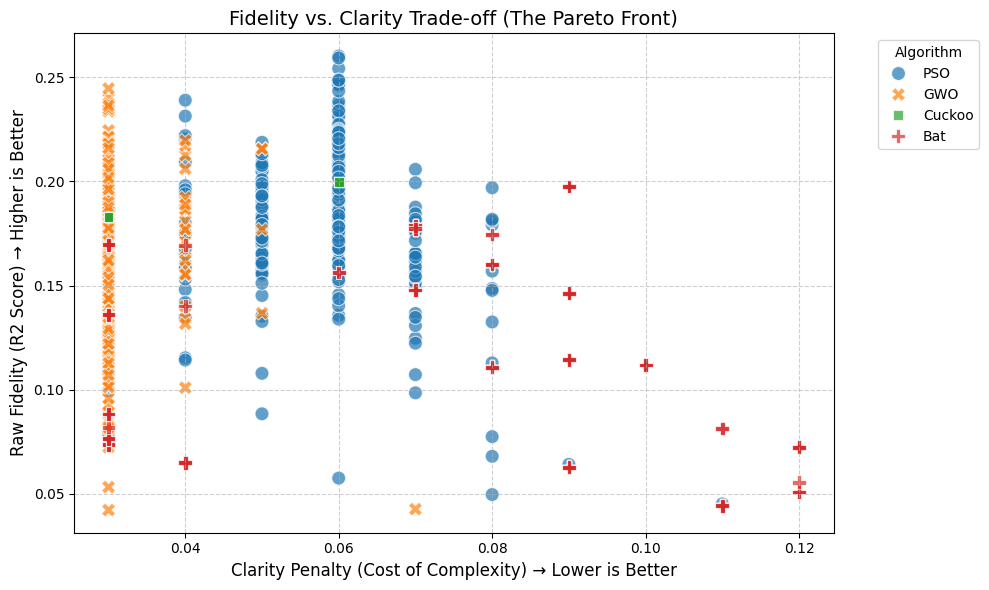

In [15]:
# Fidelity vs. Clarity Trade-off
trace = pd.read_csv(XAI_TRACE)

# Extract Components (approximate reconstruction from params)
# We re-calculate the Clarity Cost based on the 'num_features' recorded
def get_clarity_cost(row_json):
    params = json.loads(row_json)
    # Clarity Penalty formula: (num_features / 20) * 0.2
    return (params['num_features'] / 20.0) * 0.2

trace['clarity_penalty'] = trace['params'].apply(get_clarity_cost)
trace['raw_fidelity'] = trace['fitness'] + trace['clarity_penalty']


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=trace,
    x="clarity_penalty",
    y="raw_fidelity",
    hue="algorithm",
    style="algorithm",
    s=100,
    alpha=0.7
)

plt.title("Fidelity vs. Clarity Trade-off (The Pareto Front)", fontsize=14)
plt.xlabel("Clarity Penalty (Cost of Complexity) → Lower is Better", fontsize=12)
plt.ylabel("Raw Fidelity (R2 Score) → Higher is Better", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()